# Imports

In [1]:
import os

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

import catboost
import xgboost

In [2]:
import sklearn
from sklearn import set_config

In [3]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.4.1.post1


In [4]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [5]:
set_config(transform_output="pandas")

In [6]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [7]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [8]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [9]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.ipynb_checkpoints',
 'Benchmark_20240421.ipynb',
 'catboost_info',
 'input',
 'notebooks',
 'outputs',
 'requirements.txt',
 'requirements_py310.txt',
 'venvs',
 'videos']

# Helper functions

In [10]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading & EDA

In [52]:
X, _ = load_data()

In [158]:
X["Spa"]

PassengerId
0001_01       0.0
0002_01     549.0
0003_01    6715.0
0003_02    3329.0
0004_01     565.0
            ...  
9276_01    1643.0
9278_01       0.0
9279_01       1.0
9280_01     353.0
9280_02       0.0
Name: Spa, Length: 8693, dtype: float64

In [54]:
X["Cabin"]

PassengerId
0001_01       B/0/P
0002_01       F/0/S
0003_01       A/0/S
0003_02       A/0/S
0004_01       F/1/S
             ...   
9276_01      A/98/P
9278_01    G/1499/S
9279_01    G/1500/S
9280_01     E/608/S
9280_02     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [57]:
X_ = X["Cabin"].str.split("/", expand = True)

In [61]:
X_.rename(
    columns = {
        0:"FirstLetter",
        1:"MiddleLetter",
        2:"LastLetter"
    },
    inplace = True
)

In [64]:
X = pd.concat(
    [
        X,
        X_
    ],
    axis = 1
)

In [67]:
X.shape

(8693, 16)

In [66]:
X["MiddleLetter"].nunique()

1817

In [70]:
X["MiddleLetter"].isnull().sum()

199

In [72]:
X["MiddleLetter"] = X["MiddleLetter"].astype(float)

In [93]:
X["MiddleLetter"] = X["MiddleLetter"].fillna(2_000)

In [115]:
gbdf = (
    X
    .groupby(["MiddleLetter"])
    .agg(
        mean_transported  = ("Transported", np.mean),
        nr_transported  = ("Transported", len)
    )
    .reset_index()
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/244760768.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [116]:
gbdf

,MiddleLetter,mean_transported,nr_transported
0,0.0,0.333333,18
1,1.0,0.666667,15
2,2.0,0.454545,11
3,3.0,0.687500,16
4,4.0,0.285714,7
...,...,...,...
1813,1891.0,1.000000,1
1814,1892.0,0.000000,1
1815,1893.0,1.000000,1
1816,1894.0,0.000000,1


In [117]:
gbdf[gbdf["MiddleLetter"] >= 1_000]

,MiddleLetter,mean_transported,nr_transported
998,1000.0,0.500000,6
999,1001.0,0.666667,3
1000,1002.0,0.666667,6
1001,1003.0,0.500000,2
1002,1004.0,1.000000,3
...,...,...,...
1813,1891.0,1.000000,1
1814,1892.0,0.000000,1
1815,1893.0,1.000000,1
1816,1894.0,0.000000,1


In [118]:
gbdf[(gbdf["nr_transported"] == 1) & (gbdf["MiddleLetter"] >= 1_000)]

,MiddleLetter,mean_transported,nr_transported
1015,1017.0,0.0,1
1038,1040.0,1.0,1
1045,1048.0,0.0,1
1046,1049.0,0.0,1
1048,1051.0,0.0,1
...,...,...,...
1811,1886.0,1.0,1
1813,1891.0,1.0,1
1814,1892.0,0.0,1
1815,1893.0,1.0,1


In [119]:
gbdf[(gbdf["nr_transported"] == 1) & (gbdf["MiddleLetter"] >= 1_000)]

,MiddleLetter,mean_transported,nr_transported
1015,1017.0,0.0,1
1038,1040.0,1.0,1
1045,1048.0,0.0,1
1046,1049.0,0.0,1
1048,1051.0,0.0,1
...,...,...,...
1811,1886.0,1.0,1
1813,1891.0,1.0,1
1814,1892.0,0.0,1
1815,1893.0,1.0,1


In [120]:
gbdf[gbdf["nr_transported"] == 1]

,MiddleLetter,mean_transported,nr_transported
345,345.0,0.0,1
353,353.0,1.0,1
382,382.0,0.0,1
560,560.0,1.0,1
605,605.0,1.0,1
...,...,...,...
1811,1886.0,1.0,1
1813,1891.0,1.0,1
1814,1892.0,0.0,1
1815,1893.0,1.0,1


<Axes: ylabel='Density'>

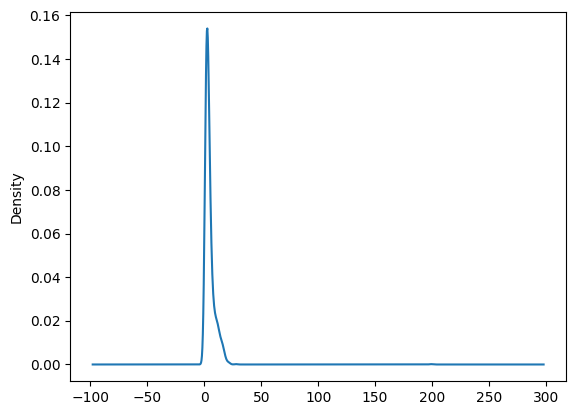

In [121]:
(
    X["MiddleLetter"]
    .value_counts()
    .sort_index()
    .plot(kind = "kde")
)

In [153]:
kbins = KBinsDiscretizer(
    n_bins = 20,
    strategy = "uniform",
    encode = "ordinal"
)

X["MiddleLetterBinned"] = kbins.fit_transform(X[["MiddleLetter"]])

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [154]:
gbdf = (
    X
    .groupby(["MiddleLetterBinned"])
    .agg(
        mean_transported  = ("Transported", np.mean),
        nr_transported  = ("Transported", len)
    )
    .reset_index()
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/501919948.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [155]:
gbdf.head()

,MiddleLetterBinned,mean_transported,nr_transported
0,0.0,0.530428,1331
1,1.0,0.537801,1164
2,2.0,0.548357,1065
3,3.0,0.434397,564
4,4.0,0.362445,458


<Axes: ylabel='MiddleLetterBinned'>

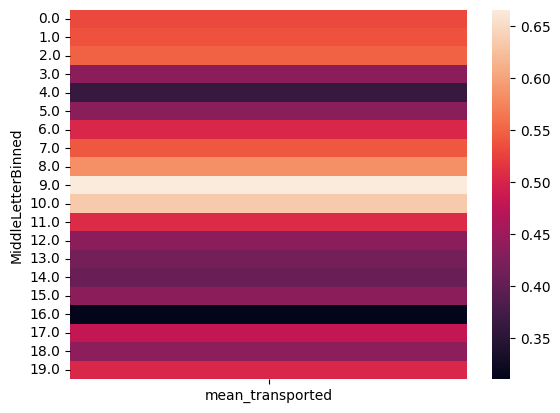

In [156]:
sns.heatmap(gbdf.set_index("MiddleLetterBinned")[["mean_transported"]])

In [152]:
X["TotalExpenses"] = X.iloc[:, 6:11].sum(axis = 1)

In [15]:
(
    X
    .groupby(["HomePlanet"])
    .agg(
        sum_expenses = ("TotalExpenses", np.sum),
        mean_expenses = ("TotalExpenses", np.mean),
        mean_transported = ("Transported", np.mean)
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/2080782346.py:2: FutureWarning: The provided callable <function sum at 0x1074d6e60> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/2080782346.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


,sum_expenses,mean_expenses,mean_transported
HomePlanet,,,
Earth,3098699.0,673.337462,0.423946
Europa,7355412.0,3451.624589,0.658846
Mars,1849161.0,1051.256964,0.523024


In [16]:
X["TotalExpenses"]

PassengerId
0001_01        0.0
0002_01      736.0
0003_01    10383.0
0003_02     5176.0
0004_01     1091.0
            ...   
9276_01     8536.0
9278_01        0.0
9279_01     1873.0
9280_01     4637.0
9280_02     4826.0
Name: TotalExpenses, Length: 8693, dtype: float64

<Axes: ylabel='Density'>

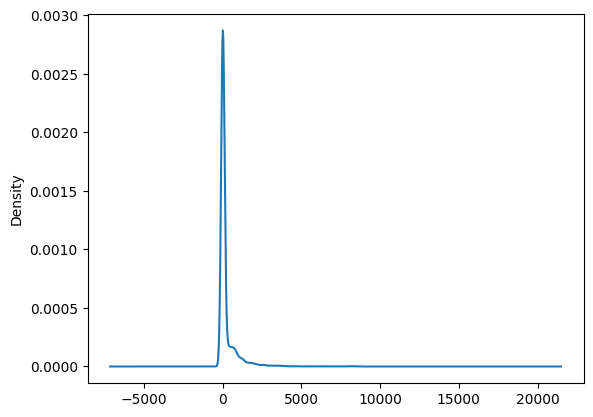

In [17]:
X["RoomService"].plot(kind = "kde")

In [18]:
X["RoomService"].value_counts().sort_index()

RoomService
0.0        5577
1.0         117
2.0          79
3.0          61
4.0          47
           ... 
8209.0        1
8243.0        1
8586.0        1
9920.0        1
14327.0       1
Name: count, Length: 1273, dtype: int64

In [19]:
nulls_per_row = X.isnull()

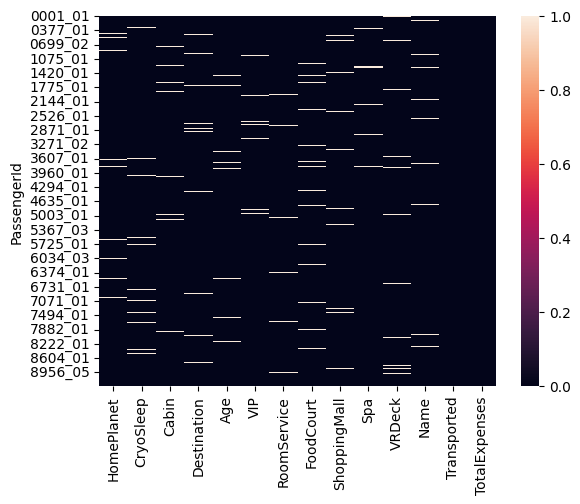

In [20]:
sns.heatmap(nulls_per_row);

In [21]:
def bucketize_age(age):
    
    if 0 <= age < 10:
        return "[0-10)"
    
    elif 10 <= age < 20:
        return "[10-20)"
    
    elif 20 <= age < 30:
        return "[20-30)"
    
    elif 30 <= age < 40:
        return "[30-40)"
    
    elif 40 <= age < 50:
        return "[40-50)"
    
    elif 50 <= age < 60:
        return "[50-60)" 
    
    elif 60 <= age < 70:
        return "[60-70)"
    
    elif age >= 70:
        return "[70 - inf"

In [22]:
Xc = X.copy(deep=True).dropna()

In [23]:
Xc["AgeBuketized"] = Xc["Age"].apply(bucketize_age)

Xc["AgeKBinsDiscretized"] = KBinsDiscretizer(
    encode = "ordinal",
    strategy = "uniform",
    n_bins = 8
).fit_transform(Xc[["Age"]].dropna())

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [26]:
Xc[["AgeKBinsDiscretized", "AgeBuketized"]].drop_duplicates().sort_values("AgeKBinsDiscretized")

,AgeKBinsDiscretized,AgeBuketized
PassengerId,,
0017_01,0.0,[0-10)
0004_01,1.0,[10-20)
0002_01,2.0,[20-30)
0001_01,3.0,[30-40)
0005_01,4.0,[40-50)
0003_01,5.0,[50-60)
0062_01,6.0,[60-70)
0378_03,7.0,[70 - inf


In [27]:
(
    Xc
    .pivot_table(
        index = "AgeBuketized",
        columns = "AgeKBinsDiscretized",
        values = "Age",
        aggfunc = len,
        margins = True,
        fill_value = 0
    )
)

AgeKBinsDiscretized,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
AgeBuketized,,,,,,,,,
[0-10),532,0,0,0,0,0,0,0,532
[10-20),0,1138,0,0,0,0,0,0,1138
[20-30),0,0,2131,0,0,0,0,0,2131
[30-40),0,0,0,1358,0,0,0,0,1358
[40-50),0,0,0,0,812,0,0,0,812
[50-60),0,0,0,0,0,438,0,0,438
[60-70),0,0,0,0,0,0,161,0,161
[70 - inf,0,0,0,0,0,0,0,36,36
All,532,1138,2131,1358,812,438,161,36,6606


In [28]:
Xc[["AgeKBinsDiscretized", "AgeBuketized", "Age"]].drop_duplicates().sort_values("Age")

,AgeKBinsDiscretized,AgeBuketized,Age
PassengerId,,,
0017_01,0.0,[0-10),0.0
0020_01,0.0,[0-10),1.0
0031_02,0.0,[0-10),2.0
0092_03,0.0,[0-10),3.0
0044_02,0.0,[0-10),4.0
...,...,...,...
1222_01,7.0,[70 - inf,75.0
1455_05,7.0,[70 - inf,76.0
3176_01,7.0,[70 - inf,77.0


In [29]:
r_ = (
    Xc
    .groupby("AgeBuketized")
    .agg(
        nr = ("CryoSleep", len),
        mean_transported = ("Transported", np.mean)
    )
    .reset_index()
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/125699061.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  Xc


In [30]:
r_

,AgeBuketized,nr,mean_transported
0,[0-10),532,0.721805
1,[10-20),1138,0.534271
2,[20-30),2131,0.474894
3,[30-40),1358,0.443299
4,[40-50),812,0.502463
5,[50-60),438,0.495434
6,[60-70),161,0.503106
7,[70 - inf,36,0.416667


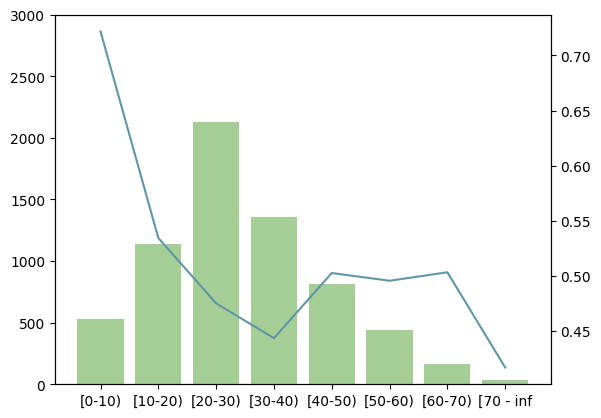

In [31]:
fig = plt.figure()
ax = fig.subplots()

ax.bar(x = r_["AgeBuketized"], height = r_["nr"], color = "#A4CE95")

ax.set_ylim(bottom=0, top=3000)

ax2 = ax.twinx()

ax2.plot(r_["mean_transported"], color = "#6196A6");

In [32]:
(X.isnull().sum(axis = 1) == X.shape[1]).sum()

0

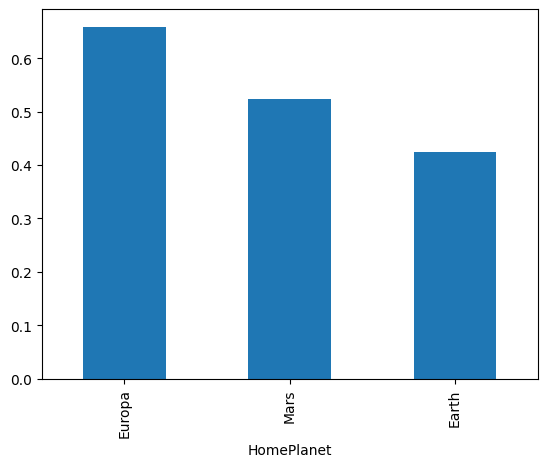

In [33]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [34]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0


In [35]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
);

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/3554285840.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [36]:
_

nr_rows  transported_ratio  nr_rows_pct
HomePlanet CryoSleep                                         
Earth      False         3106              32.10        37.53
           True          1382              65.63        16.70
Europa     False         1162              40.02        14.04
           True           911              98.90        11.01
Mars       False         1047              27.70        12.65
           True           669              91.18         8.08

In [37]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [38]:
X.groupby(["LenCabin"]).size()

LenCabin
3     199
5     130
6    1201
7    5043
8    2120
dtype: int64

In [39]:
X[X["LenCabin"] == 5].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,LenCabin
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,5
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,5
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,5
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,5
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,5


In [40]:
X["Cabin"].fillna("NA", inplace = True)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/3468940878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Cabin"].fillna("NA", inplace = True)


In [41]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)
X["CabinLastLetter"] = X["Cabin"].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin)

In [42]:
X["CabinFirstLetter"].value_counts().sort_index()

CabinFirstLetter
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [43]:
X["CabinLastLetter"].value_counts().sort_index()

CabinLastLetter
NA     199
P     4206
S     4288
Name: count, dtype: int64

In [44]:
X["Cabin"].sample(10)

PassengerId
5480_01          NA
8135_01     C/267/P
6229_01    F/1286/P
2409_02     G/390/P
6968_01    F/1447/P
3395_01     G/542/S
9152_01    G/1491/P
1562_01     F/306/P
1700_02      B/74/S
8930_01    F/1725/S
Name: Cabin, dtype: object

In [45]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinFirstLetter
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
NA    0.502513
T     0.200000
Name: Transported, dtype: float64

In [46]:
(
    X
    .groupby(["CabinLastLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinLastLetter
NA    0.502513
P     0.451260
S     0.555037
Name: Transported, dtype: float64

In [47]:
pd.concat([
    (
        X
        .groupby(["CabinFirstLetter", "CabinLastLetter"])
        ["Transported"]
        .mean()
        .sort_index()
        .unstack()
    ),
    (
        X
        .groupby(["CabinFirstLetter"])
        ["Transported"]
        .mean()
        .sort_index()
    )], axis = 1)

,NA,P,S,Transported
CabinFirstLetter,,,,
A,NaN,0.435897,0.546763,0.496094
B,NaN,0.674221,0.784038,0.734275
C,NaN,0.580645,0.763547,0.680054
D,NaN,0.403226,0.465217,0.433054
E,NaN,0.342657,0.371365,0.357306
F,NaN,0.410987,0.470501,0.439871
G,NaN,0.448276,0.583788,0.516217
NA,0.502513,NaN,NaN,0.502513
T,NaN,0.250000,0.000000,0.200000


In [48]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses,LenCabin
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329,6.984240
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694,0.898869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000,7.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,8.000000


In [49]:
X.isnull().sum()

HomePlanet          201
CryoSleep           217
Cabin                 0
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
Transported           0
TotalExpenses         0
LenCabin              0
CabinFirstLetter      0
CabinLastLetter       0
dtype: int64

In [50]:
X.shape

(8693, 17)

In [51]:
(
    X
    .pivot_table(
        index = "HomePlanet",
        columns = "Destination",
        values = "Transported",
        aggfunc = [len, np.mean],
        margins = True
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_48438/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x1074d7d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


len                                        mean  \
Destination 55 Cancri e PSO J318.5-22 TRAPPIST-1e   All 55 Cancri e   
HomePlanet                                                            
Earth               690           712        3101  4503    0.504348   
Europa              886            19        1189  2094    0.689616   
Mars                193            49        1475  1717    0.611399   
All                1769           780        5765  8314    0.608819   

                                                 
Destination PSO J318.5-22 TRAPPIST-1e       All  
HomePlanet                                       
Earth            0.498596    0.389229  0.424162  
Europa           0.736842    0.634987  0.659026  
Mars             0.448980    0.511864  0.521258  
All              0.501282    0.471292  0.503368

In [ ]:
X["Name"].fillna("NA").apply(lambda name: len(name.split(" "))).value_counts()

In [ ]:
X.head()

In [ ]:
X["Surname"] = X["Name"].fillna("NA").apply(lambda name: name.split(" ")[1] if name != "NA" else name)

In [ ]:
X["Surname"]

In [ ]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
)

In [ ]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
    .value_counts(normalize=True)
    .sort_index()
)

In [ ]:
del X, _